In [2]:
#smalldata transformer
import math
import tensorflow as tf
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import os
import pickle
import sklearn.metrics as skl
from sklearn.model_selection import train_test_split
import gc
import tensorflow_addons as tfa

In [3]:
#load data
label_dict = {0 : "no_sub", 1 : "sub"}
with open('imgs.pkl', 'rb') as f:
    imgs = pickle.load(f)
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)

In [4]:
#pre processing
rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1 / 255)
])
one_hot_fun = tf.keras.Sequential([
    tf.keras.layers.CategoryEncoding(num_tokens=2, output_mode="one_hot")
])

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.1, shuffle=True)

train_imgs = rescale(train_imgs)
test_imgs = rescale(test_imgs)
train_labels = one_hot_fun(train_labels)
test_labels = one_hot_fun(test_labels)

def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=orthogonal_rot
)

In [4]:
#hyperparams
BATCH_SIZE = 256
IMAGE_SIZE = 150
PATCH_SIZE = 15
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
EPOCHS = 50
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 6
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [512, 64]

In [5]:
#create shifted images and patches
class ShiftedPatchTokenization(tf.keras.layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = tf.keras.layers.Reshape((num_patches, -1))
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        images = tf.concat(
            [
                images,
                self.crop_shift_pad(images, mode="left-up"),
                self.crop_shift_pad(images, mode="left-down"),
                self.crop_shift_pad(images, mode="right-up"),
                self.crop_shift_pad(images, mode="right-down"),
            ],
            axis=-1,
        )
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        tokens = self.layer_norm(flat_patches)
        tokens = self.projection(tokens)
        return (tokens, patches)

ORIGINAL


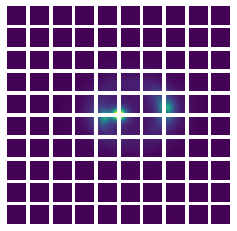

LEFT-UP


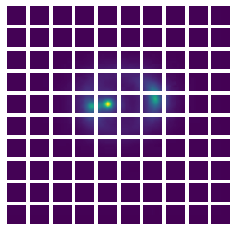

LEFT-DOWN


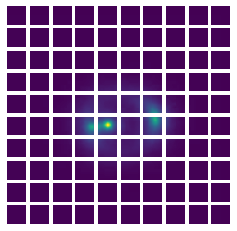

RIGHT-UP


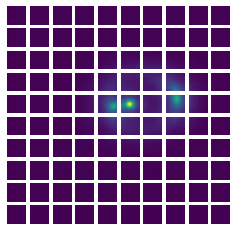

RIGHT-DOWN


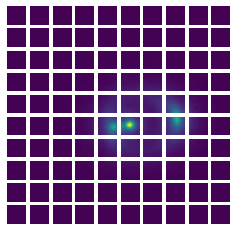

In [6]:
#plotting data
# image = train_imgs[np.random.choice(range(train_imgs.shape[0]))]
# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
# )

# (token, patch) = ShiftedPatchTokenization()(resized_image)
# (token, patch) = (token[0], patch[0])
# n = patch.shape[0]
# shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
# for index, name in enumerate(shifted_images):
#     print(name)
#     count = 1
#     plt.figure(figsize=(4, 4))
#     for row in range(n):
#         for col in range(n):
#             plt.subplot(n, n, count)
#             count = count + 1
#             image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 1))
#             plt.imshow(image[..., index : index + 1], vmin=0, vmax=1)
#             plt.axis("off")
#     plt.show()

In [7]:
#encoder
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [8]:
#attention
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [9]:
#mlp and attention mask
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [10]:
#vit model
def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=(150,150,1))
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization()(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttentionLSA(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1, attention_mask=diag_attn_mask)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.2)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.2)
    # Classify outputs.
    logits = tf.keras.layers.Dense(2)(features)
    logits = tf.keras.layers.Activation('softmax')(logits)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)

    model.compile(
    optimizer= tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = tf.keras.metrics.CategoricalAccuracy()
    )
    return model

model = create_vit_classifier()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 shifted_patch_tokenization_1 (  ((None, 100, 64),   74314       ['input_1[0][0]']                
 ShiftedPatchTokenization)       (None, 10, 10, 112                                               
                                5))                                                               
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 100, 64)      6400        ['shifted_patch_tokenization_

In [11]:
#train moodel
model.fit(
    datagen.flow(train_imgs, train_labels, batch_size=BATCH_SIZE),
    epochs=EPOCHS
)
model.save('lowdata_trans')

Epoch 1/50
36/36 [==============================] - 16s 240ms/step - loss: 1.1284 - categorical_accuracy: 0.4996
Epoch 2/50
36/36 [==============================] - 9s 240ms/step - loss: 0.6970 - categorical_accuracy: 0.5092
Epoch 3/50
36/36 [==============================] - 9s 242ms/step - loss: 0.6925 - categorical_accuracy: 0.5032
Epoch 4/50
36/36 [==============================] - 9s 243ms/step - loss: 0.6911 - categorical_accuracy: 0.5198
Epoch 5/50
36/36 [==============================] - 9s 244ms/step - loss: 0.6850 - categorical_accuracy: 0.5483
Epoch 6/50
36/36 [==============================] - 9s 245ms/step - loss: 0.6674 - categorical_accuracy: 0.5850
Epoch 7/50
36/36 [==============================] - 9s 246ms/step - loss: 0.6095 - categorical_accuracy: 0.6484
Epoch 8/50
36/36 [==============================] - 9s 247ms/step - loss: 0.5343 - categorical_accuracy: 0.6940
Epoch 9/50
36/36 [==============================] - 9s 251ms/step - loss: 0.4609 - categorical_accuracy

INFO:tensorflow:Assets written to: lowdata_trans_1\assets


INFO:tensorflow:Assets written to: lowdata_trans_1\assets


In [6]:
#predictions and eval
pred_label = model.predict(test_imgs)
eval = model.evaluate(test_imgs,test_labels)

32/32 [==============================] - 3s 34ms/step - loss: 0.0574 - categorical_accuracy: 0.9790


ROC AUC score: 0.9987719214029698


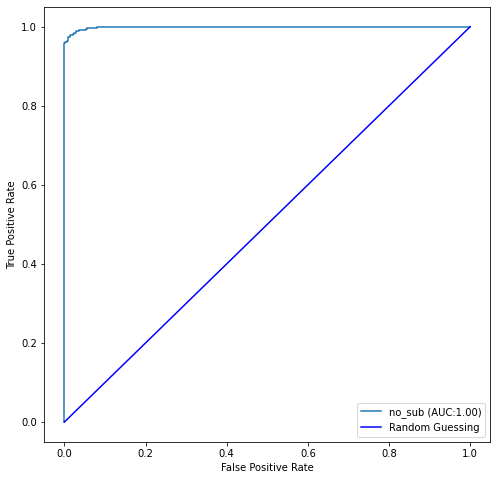

In [8]:
#roc, auc and plotting
fig, c_ax = plt.subplots(1,1, figsize = (8, 8))

fpr , tpr , thresholds = skl.roc_curve (np.array(test_labels[:,0]), np.array(pred_label[:,0]))
c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label_dict[0], skl.auc(fpr, tpr)))
c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
print('ROC AUC score:', skl.roc_auc_score(np.array(test_labels), np.array(pred_label)))
plt.show()